# Spectral Amplification

In [1]:
# import modules
import sys
sys.path.insert(1, '../src')
from MPA_model import *
import matplotlib.pyplot as plt

## Pre Amplification Steps

In [2]:
# signal parameters
SIGNAL_RESOLUTION = int(1e5)
NPERSEG = 2**11

LAMBDA0 = 800e-9 # center wavelength in meter
NU0 = lambda2nu(LAMBDA0) # center frequency in Hz
FWHM = 1e13 # in Hz
AMP = 1

PULSE_ENERGY = 2.5e-4 # in joule
INPUT_AREA = 0.045e-4 # in meter square

In [3]:
# specify amplitude of initial pulse
theta_i = np.deg2rad(33.5) # incident angle
grating_L = 129.6e-3 # grating separation
grating_d = 0.833e-6 # grating spacing

nu_range = NU0 - speed_of_light/(grating_d*(1 + np.sin(theta_i)))
initial_freq = np.linspace(NU0 - nu_range, NU0 + nu_range, SIGNAL_RESOLUTION)

initial_df = np.abs(initial_freq[1] - initial_freq[0]) # frequency step of initial pulse
initial_wavelength = nu2lambda(initial_freq)

initial_amp_f = gaussian(initial_freq, NU0, FWHM, AMP)
peak_power_f = PULSE_ENERGY / np.trapz(initial_amp_f**2, dx = initial_df) # find the peak power
initial_amp_f = np.sqrt(peak_power_f) * initial_amp_f

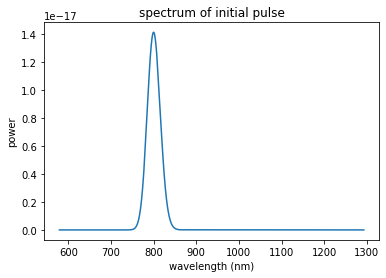

In [4]:
# plot amplitude of initial pulse
plt.plot(initial_wavelength*1e9, np.absolute(initial_amp_f) ** 2)
plt.title('spectrum of initial pulse')
plt.xlabel('wavelength (nm)')
plt.ylabel('power')
plt.show()

In [5]:
# specify phase of initial pulse
theta_r0 = np.arcsin(LAMBDA0/grating_d - np.sin(theta_i)) # reflect angle of center wavelength
k_0 = 2 * np.pi/LAMBDA0 * grating_L # phase velocity shift constant
reciprocal_vg = ((1 + np.sin(theta_i) * np.sin(theta_r0))/(speed_of_light * np.cos(theta_r0)))*grating_L
dw = 2*np.pi*(initial_freq - NU0)

initial_phase_f = 2 * np.pi / (initial_wavelength) * grating_L * np.cos(np.arcsin(initial_wavelength / grating_d - np.sin(theta_i)))
initial_phase_f -= (k_0 + reciprocal_vg*dw) # take

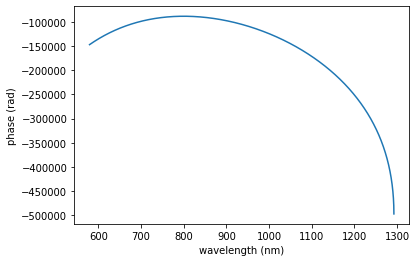

In [6]:
# plot phase of initial pulse
plt.plot(initial_wavelength * 1e9, initial_phase_f)
plt.xlabel('wavelength (nm)')
plt.ylabel('phase (rad)')
plt.show()

In [7]:
# combine amplitude and phase
initial_complex_f = polar_to_rect(initial_amp_f, initial_phase_f)

In [8]:
# transform to time domain using ifft
initial_complex_t = fftpack.ifft(initial_complex_f)
initial_time = fftpack.fftfreq(SIGNAL_RESOLUTION) * 1/initial_df

# shift the center of transformation
initial_complex_t = np.fft.fftshift(initial_complex_t)
initial_time = np.fft.fftshift(initial_time)

# rescaling to correct pulse energy
initial_amp_t, initial_phase_t = rect_to_polar(initial_complex_t)
peak_power_t = PULSE_ENERGY / np.trapz(initial_amp_t**2,  x = initial_time)
initial_amp_t = np.sqrt(peak_power_t) * initial_amp_t
initial_complex_t = polar_to_rect(initial_amp_t, initial_phase_t)

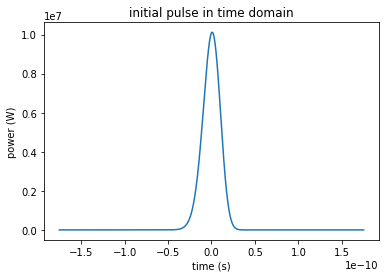

In [9]:
# convert to power
initial_power_t = np.absolute(initial_complex_t) ** 2

# plot power of initial pulse in time domain
plt.plot(initial_time, initial_power_t)
plt.title('initial pulse in time domain')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.show()

### Stretch the pulse

In [10]:
# stretcher parameters
STRETCHER_GRATING_L = 129.6e-3
STRETCHER_GRATING_D = 0.833e-6
STRETCHER_INCIDENT_ANGLE = 33.5 # in degree

# initiate stretche
stretcher = GratingPair(STRETCHER_GRATING_L, STRETCHER_GRATING_D)

# stretch the pulse
stretched_complex_t = stretcher.stretch_pulse(STRETCHER_INCIDENT_ANGLE, initial_time, initial_complex_t, NU0)

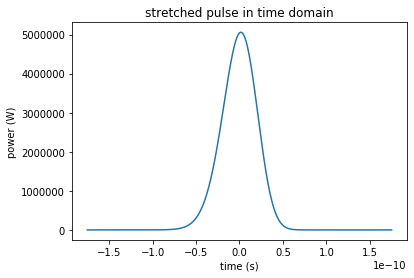

In [11]:
plt.plot(initial_time, np.absolute(stretched_complex_t)**2)
plt.title('stretched pulse in time domain')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.show()

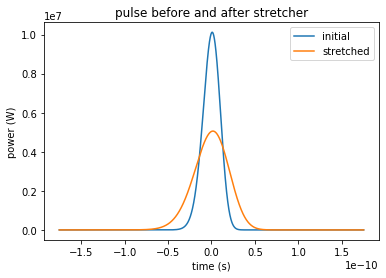

In [12]:
# plot initial pulse and stretched pulse
plt.plot(initial_time, np.absolute(initial_complex_t)**2, label = 'initial')
plt.plot(initial_time, np.absolute(stretched_complex_t)**2, label = 'stretched')
plt.title('pulse before and after stretcher')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

### Short Time Fourier Transform (STFT)

In [13]:
# stft parameters
freq_sampling = SIGNAL_RESOLUTION * initial_df # sampling frequency
fwindow = 'hann' # fourier window

# calculate stft
freq_pile, time_pile, stft_signal = signal.stft(stretched_complex_t, freq_sampling, window = fwindow, nperseg = NPERSEG, return_onesided = False)

# calculate associated frequency
freq_pile = np.fft.fftshift(freq_pile)
freq_pile += NU0

wavelength_pile = nu2lambda(freq_pile)
stft_df = np.abs(freq_pile[1] - freq_pile[0])
stft_dt = np.abs(time_pile[1] - time_pile[0])
stft_dfdt = stft_df * stft_dt

# rescaling the result to match the correct energy in the pulse
stft_energy = np.trapz(np.trapz(np.absolute(stft_signal)**2)) * stft_dfdt
stft_scaling = np.sqrt(PULSE_ENERGY / stft_energy)
stft_signal = stft_scaling * stft_signal

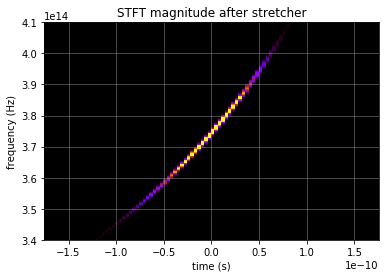

In [14]:
cmap = 'gnuplot'
vmax = 0.5
plt.pcolormesh(time_pile - np.amax(time_pile)/2, freq_pile, np.absolute(stft_signal) / np.amax(np.absolute(stft_signal)), vmax = vmax, cmap = cmap)
plt.title('STFT magnitude after stretcher')
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.ylim((3.4e14, 4.1e14))
plt.grid(alpha = 0.5)
plt.savefig('../pics/short_stft.png', quality = 0.95, dpi = 600)
plt.show()

In [15]:
# convert time series to signal pile
input_signal_pile = pack_signal_pile(wavelength_pile, stft_signal, INPUT_AREA, stft_dfdt)

## Amplification Steps

### Multipass Amplification 1 (MPA1)

In [16]:
# fit emission cross section for crystal 1 using reciprocal gaussian
CRYSTAL1_X = np.array([600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1025, 1050, 1075, 1100])
CRYSTAL1_Y = np.array([0, 0.1, 0.3, 1 ,1.6, 2.8, 3.5, 3.8, 3.9, 3.8, 3.5, 3.0, 2.4, 1.9, 1.6, 1.2, 1, 0.8, 0.6, 0.5, 0.4])
xdata = convert_unit(CRYSTAL1_X, 'nm', 'm')
ydata = convert_unit(CRYSTAL1_Y * (1e-19), 'cm^2', 'm^2')
guess = [800e-9, 100e-9, 3.9e-23]

CRYSTAL1_PARAMS = fit_emission_cross_section(xdata, ydata, guess)
CRYSTAL1_CROSS_SECTION_AMP_COR = 2/3
CRYSTAL1_CROSS_SECTION = cross_section_func(np.abs(wavelength_pile), CRYSTAL1_PARAMS, CRYSTAL1_CROSS_SECTION_AMP_COR)

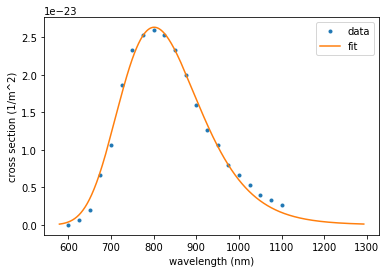

In [17]:
# plot cross section with wavelength
plt.plot(CRYSTAL1_X, CRYSTAL1_CROSS_SECTION_AMP_COR * CRYSTAL1_Y * (1e-23), '.', label = 'data')
plt.plot(wavelength_pile*1e9, CRYSTAL1_CROSS_SECTION, label = 'fit')
plt.xlabel('wavelength (nm)')
plt.ylabel('cross section (1/m^2)')
plt.legend()
plt.show()

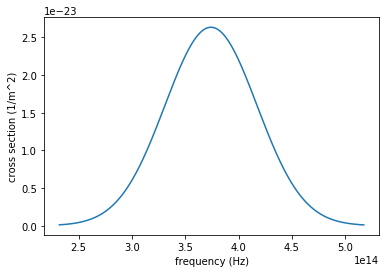

In [18]:
# plot cross section with frequency
plt.plot(freq_pile, CRYSTAL1_CROSS_SECTION)
plt.xlabel('frequency (Hz)')
plt.ylabel('cross section (1/m^2)')
plt.show()

In [19]:
# crystal 1 parameters
CRYSTAL1_ALPHA = 1.33e2 # attenuation in 1/m
CRYSTAL1_QD = 0.665 # quantum defect
CRYSTAL1_LENGTH = 15e-3 # length in meter
CRYSTAL1_N2 = 2.9e-20 # nonlinear refractive index in m^2/W

# calculate saturation fluence
CRYSTAL1_J_SAT = (Planck * np.abs(freq_pile)) / CRYSTAL1_CROSS_SECTION
CRYSTAL1_J_SAT = dict(zip(wavelength_pile, CRYSTAL1_J_SAT)) # convert to dictionary

# initiate crystal 1 object
crystal1 = Crystal(CRYSTAL1_ALPHA, CRYSTAL1_QD, CRYSTAL1_LENGTH, CRYSTAL1_N2, CRYSTAL1_J_SAT)

In [20]:
# pump energy parameters for MPA1
PUMP1_ENERGY = 0.045 # in joule
PUMP1_AREA = 0.05e-4 # in meter square
PUMP1_ENERGY_DISTRIBUTION = 'beer'
PUMP1_FRONT_PUMP = True
PUMP1_BACK_PUMP = True

# initiate pump 1 object
pump1 = Pump(PUMP1_ENERGY, PUMP1_AREA)

In [21]:
# multipass amplifier (MPA) 1 parameters
MPA1_CRYSTAL_RESOLUTION = 10 # number of crystal splits
MPA1_NUMPASS = 4 # number of passes
MPA1_LOSS_PER_PATH = 0 # percent of energy loss per path

#initiate MPA 1 
m1 = MultiPassAmplifier(crystal1)
m1.set_crystal_res(MPA1_CRYSTAL_RESOLUTION)
m1.set_loss_per_path(MPA1_LOSS_PER_PATH)
m1.clear_passes()

In [22]:
# calculate stored energy 
store1 = m1.calculate_stored_energy_from_pump(pump1, PUMP1_ENERGY_DISTRIBUTION, front_pump = PUMP1_FRONT_PUMP, back_pump = PUMP1_BACK_PUMP)

In [23]:
# amplify the signal
after_MPA1_signal_pile = m1.calculate_multi_pass_amplification(store1, input_signal_pile, MPA1_NUMPASS)

In [24]:
# unpack signal pile back
after_MPA1_stft_signal = unpack_signal_pile(after_MPA1_signal_pile, stft_dfdt)

# rescaling for istft
after_MPA1_stft_signal = after_MPA1_stft_signal / stft_scaling

# istft
after_MPA1_time, after_MPA1_complex_t = signal.istft(after_MPA1_stft_signal, freq_sampling, window = fwindow, input_onesided = False)
after_MPA1_time = after_MPA1_time - np.amax(after_MPA1_time)/2 # shift time to be centered at zero

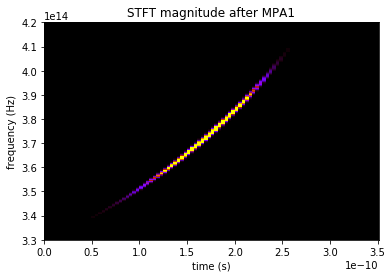

In [25]:
cmap = 'gnuplot'
vmax = 0.25
plt.pcolormesh(time_pile, freq_pile, np.absolute(after_MPA1_stft_signal) / np.amax(np.absolute(after_MPA1_stft_signal)), vmax = vmax, cmap = cmap)
plt.title('STFT magnitude after MPA1')
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.ylim((3.3e14, 4.2e14))
plt.show()

/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


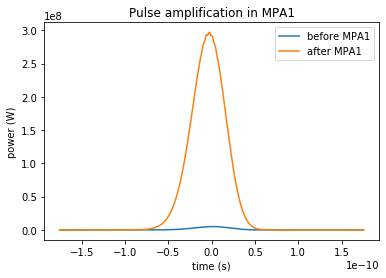

In [26]:
# convert to power
stretched_power_t = np.absolute(stretched_complex_t)**2
after_MPA1_power_t = np.absolute(after_MPA1_complex_t)**2

# plot pulse before and after amplification
plt.plot(initial_time, stretched_power_t, label = 'before MPA1')
plt.plot(after_MPA1_time, after_MPA1_power_t, label = 'after MPA1')
plt.title('Pulse amplification in MPA1')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

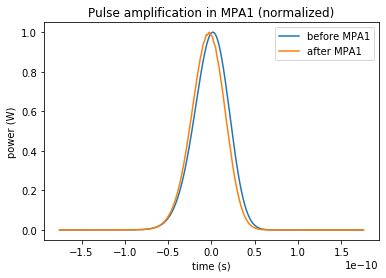

In [27]:
# plot pulse before and after amplification
plt.plot(initial_time, stretched_power_t / np.amax(stretched_power_t), label = 'before MPA1')
plt.plot(after_MPA1_time, after_MPA1_power_t / np.amax(after_MPA1_power_t), label = 'after MPA1')
plt.title('Pulse amplification in MPA1 (normalized)')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

### Pockels Cell

In this simulation, Pockels cell only takes off energy from the pulse. We also increase the pulse area.

In [28]:
# split parameters
PC_ENERGY_LOSS = 0.2
ENERGY_MULTIPLIER = 1 - PC_ENERGY_LOSS
AREA_MULTIPLIER = 40

# initiate signal manipulator
signal_manip = SignalManipulator()
after_pockels_signal_pile = signal_manip.manipulate_signal_pile(after_MPA1_signal_pile, ENERGY_MULTIPLIER, 0, AREA_MULTIPLIER, 0)

after_pockels_signal_pile[50][1000].E_in

3.928704292072584e-14

In [29]:
# unpack signal pile back
after_pockels_stft_signal = unpack_signal_pile(after_pockels_signal_pile, stft_dfdt)

# rescaling for istft
after_pockels_stft_signal = after_pockels_stft_signal / stft_scaling

# istft
after_pockels_time, after_pockels_complex_t = signal.istft(after_pockels_stft_signal, freq_sampling, window = fwindow, input_onesided = False)
after_pockels_time = after_pockels_time - np.amax(after_pockels_time)/2 # shift time to be centered at zero

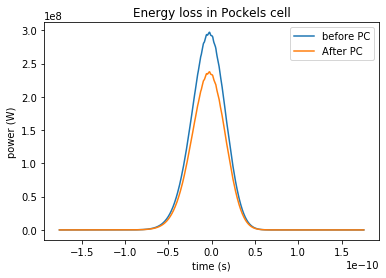

In [30]:
# convert to power
after_pockels_power_t = np.absolute(after_pockels_complex_t)**2

# plot pulse before and after amplification
plt.plot(after_MPA1_time, after_MPA1_power_t, label = 'before PC')
plt.plot(after_pockels_time, after_pockels_power_t, label = 'After PC')
plt.title('Energy loss in Pockels cell')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

### Multiplass Amplifier 2 (MPA2)

In [31]:
# crystal 2 parameters
CRYSTAL2_ALPHA = 1.32e2 # attenuation in 1/m
CRYSTAL2_QD = 0.665 # quantum defect
CRYSTAL2_LENGTH = 20e-3 # length in meter
CRYSTAL2_N2 = 2.9e-20 # nonlinear refractive index in m^2/W

# use Ti:Sapphire as well
CRYSTAL2_CROSS_SECTION = CRYSTAL1_CROSS_SECTION

# calculate saturation fluence
CRYSTAL2_J_SAT = (Planck * np.abs(freq_pile)) / CRYSTAL1_CROSS_SECTION
CRYSTAL2_J_SAT = dict(zip(wavelength_pile, CRYSTAL2_J_SAT)) # convert to dictionary

# initiate crystal 2 object
crystal2 = Crystal(CRYSTAL2_ALPHA, CRYSTAL2_QD, CRYSTAL2_LENGTH, CRYSTAL2_N2, CRYSTAL2_J_SAT)

In [32]:
# pump energy parameters for MPA 2
PUMP2_ENERGY = 3.1 # in joule
PUMP2_AREA = 2e-4 # in meter square
PUMP2_ENERGY_DISTRIBUTION = 'beer'
PUMP2_FRONT_PUMP = True
PUMP2_BACK_PUMP = True

# initiate pump 2 object
pump2 = Pump(PUMP2_ENERGY, PUMP2_AREA)

In [33]:
# multipass amplifier (MPA2) parameters
MPA2_CRYSTAL_RESOLUTION = 10 # number of crystal splits
MPA2_NUMPASS = 3 # number of passes
MPA2_LOSS_PER_PATH = 0 # percent of energy loss per path

#initiate MPA 1 
m2 = MultiPassAmplifier(crystal2)
m2.set_crystal_res(MPA2_CRYSTAL_RESOLUTION)
m2.set_loss_per_path(MPA2_LOSS_PER_PATH)
m2.clear_passes()

In [34]:
# calculate stored energy 
store2 = m2.calculate_stored_energy_from_pump(pump2, PUMP2_ENERGY_DISTRIBUTION, front_pump = PUMP2_FRONT_PUMP, back_pump = PUMP2_BACK_PUMP)

In [35]:
# amplify the signal
after_MPA2_signal_pile = m2.calculate_multi_pass_amplification(store2, after_pockels_signal_pile, MPA2_NUMPASS)

In [36]:
# unpack signal pile back
after_MPA2_stft_signal = unpack_signal_pile(after_MPA2_signal_pile, stft_dfdt)

# rescaling for istft
after_MPA2_stft_signal = after_MPA2_stft_signal / stft_scaling

# istft
after_MPA2_time, after_MPA2_complex_t = signal.istft(after_MPA2_stft_signal, freq_sampling, window = fwindow, input_onesided = False)
after_MPA2_time = after_MPA2_time - np.amax(after_MPA2_time)/2 # shift time to be centered at zero

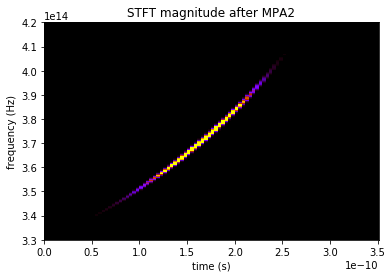

In [37]:
cmap = 'gnuplot'
vmax = 0.25
plt.pcolormesh(time_pile, freq_pile, np.absolute(after_MPA2_stft_signal) / np.amax(np.absolute(after_MPA2_stft_signal)), vmax = vmax, cmap = cmap)
plt.title('STFT magnitude after MPA2')
plt.xlabel('time (s)')
plt.ylabel('frequency (Hz)')
plt.ylim((3.3e14, 4.2e14))
plt.show()

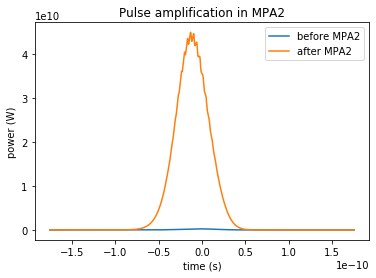

In [38]:
# convert to power
after_MPA2_power_t = np.absolute(after_MPA2_complex_t)**2

# plot pulse before and after amplification
plt.plot(after_pockels_time, after_pockels_power_t, label = 'before MPA2')
plt.plot(after_MPA2_time, after_MPA2_power_t, label = 'after MPA2')
plt.title('Pulse amplification in MPA2')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

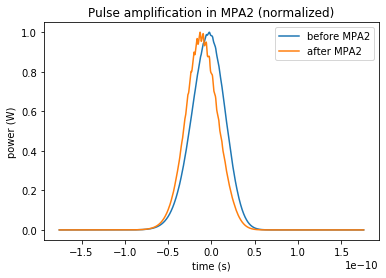

In [39]:
# plot pulse before and after amplification
plt.plot(after_pockels_time, after_pockels_power_t / np.amax(after_pockels_power_t), label = 'before MPA2')
plt.plot(after_MPA2_time, after_MPA2_power_t / np.amax(after_MPA2_power_t), label = 'after MPA2')
plt.title('Pulse amplification in MPA2 (normalized)')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

## Post Amplification Steps

### Inverse Short Time Fourier Transform (ISTFT)

### Compress the pulse

In [40]:
# compressor parameters
COMPRESSOR_GRATING_L = 129.6e-3
COMPRESSOR_GRATING_D = 0.833e-6
COMPRESSOR_INCIDENT_ANGLE = 33.5 # in degree

# initiate compressor
compressor = GratingPair(STRETCHER_GRATING_L, STRETCHER_GRATING_D)

# compress the pulse
compressed_complex_t = compressor.compress_pulse(COMPRESSOR_INCIDENT_ANGLE, after_MPA2_time, after_MPA2_complex_t, NU0)

In [41]:
# convert to power
compressed_power_t = np.absolute(compressed_complex_t)**2

In [42]:
# calculate full width at half maximum for initial and final pulse
in_FWHM = find_FWHM(initial_time,  np.absolute(initial_complex_t)**2)
out_FWHM = find_FWHM(after_MPA2_time,  np.absolute(compressed_complex_t)**2)
print('FWHM of input pulse (s) : ' + str(in_FWHM))
print('FWHM of output pulse (s) : ' + str(out_FWHM))

FWHM of input pulse (s) : 2.3148028786982192e-11
FWHM of output pulse (s) : 2.1184314262636637e-11


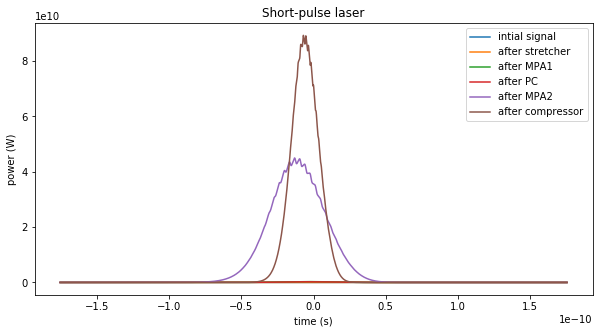

In [43]:
plt.figure(figsize = (10, 5))
plt.plot(initial_time, initial_power_t, label = 'intial signal')
plt.plot(initial_time, stretched_power_t, label = 'after stretcher')
plt.plot(after_MPA1_time, after_MPA1_power_t, label = 'after MPA1')
plt.plot(after_pockels_time, after_pockels_power_t, label = 'after PC')
plt.plot(after_MPA2_time, after_MPA2_power_t, label = 'after MPA2')
plt.plot(after_MPA2_time, compressed_power_t, label = 'after compressor')
plt.title('Short-pulse laser')
plt.xlabel('time (s)')
plt.ylabel('power (W)')
plt.legend()
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]


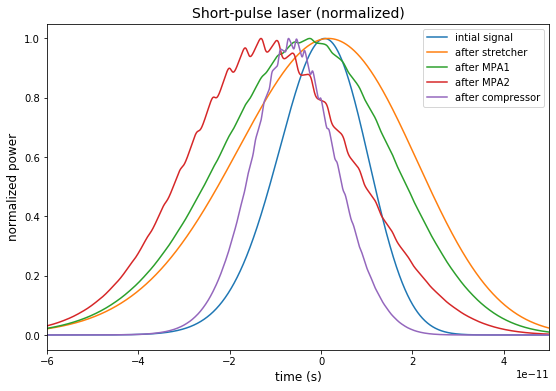

In [44]:
plt.figure(figsize = (9, 6))
plt.plot(initial_time, initial_power_t / np.amax(initial_power_t), label = 'intial signal')
plt.plot(initial_time, stretched_power_t / np.amax(stretched_power_t), label = 'after stretcher')
plt.plot(after_MPA1_time, after_MPA1_power_t / np.amax(after_MPA1_power_t), label = 'after MPA1')
#plt.plot(after_pockels_time, after_pockels_power_t / np.amax(after_pockels_power_t), label = 'after PC')
plt.plot(after_MPA2_time, after_MPA2_power_t / np.amax(after_MPA2_power_t), label = 'after MPA2')
plt.plot(after_MPA2_time, compressed_power_t / np.amax(compressed_power_t), label = 'after compressor')
plt.title('Short-pulse laser (normalized)', fontsize = 14)
plt.xlabel('time (s)', fontsize = 12)
plt.ylabel('normalized power', fontsize = 12)
plt.legend()
plt.xlim((-0.6e-10, 0.5e-10))
plt.savefig('../pics/short_example.png', quality = 95, dpi = 600)
plt.show()

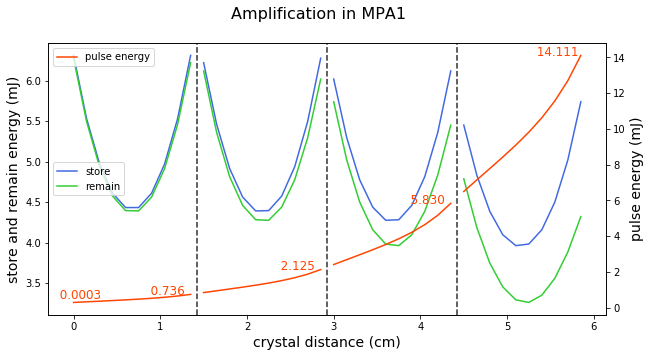

In [46]:
store_data = m1.plot_multi_pass_store_energy()
remain_data = m1.plot_multi_pass_remain_energy()

output_data = m1.plot_multi_pass_output_energy()

fig, ax1 = plt.subplots(figsize = (10,5))

plot_multi_pass_data(ax1, MPA1_NUMPASS, [store_data, remain_data], ['royalblue', 'limegreen'], ['store', 'remain'], 1e2, 1e3, 'center left')
ax1.set_xlabel('crystal distance (cm)', fontsize  = 14)
ax1.set_ylabel('store and remain energy (mJ)', fontsize = 14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plot_multi_pass_data(ax2, MPA1_NUMPASS, [output_data], ['orangered'], ['pulse energy'], 1e2, 1e3, 'best')
ax2.set_ylabel('pulse energy (mJ)', fontsize = 14)

output_x, output_y = output_data
val = output_y[0]
ax2.text(output_x[0] - 0.25, val + 0.5, "{0:8.4f}".format(val), c = 'orangered', fontsize = 12)
plot_multi_pass_last_value(ax2, MPA1_NUMPASS, output_data, 'orangered', '{0:8.3f}', 1e2, 1e3, -0.6, 0, 12)

fig.suptitle('Amplification in MPA1', fontsize = 16)
# fig.savefig('../pics/short_MPA1.png')
plt.show()

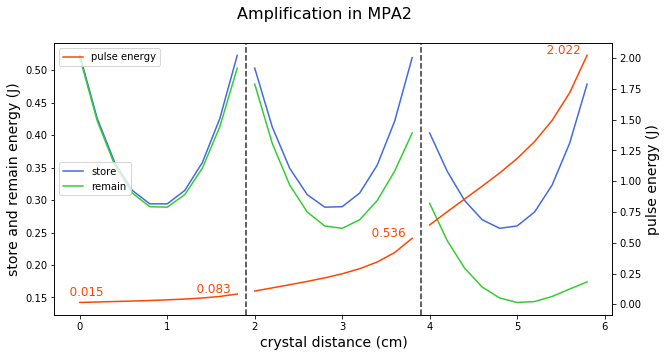

In [47]:
store_data = m2.plot_multi_pass_store_energy()
remain_data = m2.plot_multi_pass_remain_energy()

output_data = m2.plot_multi_pass_output_energy()

fig, ax1 = plt.subplots(figsize = (10,5))

plot_multi_pass_data(ax1, MPA2_NUMPASS, [store_data, remain_data], ['royalblue', 'limegreen'], ['store', 'remain'], 1e2, 1, 'center left')
ax1.set_xlabel('crystal distance (cm)', fontsize  = 14)
ax1.set_ylabel('store and remain energy (J)', fontsize = 14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

plot_multi_pass_data(ax2, MPA2_NUMPASS, [output_data], ['orangered'], ['pulse energy'], 1e2, 1, 'best')
ax2.set_ylabel('pulse energy (J)', fontsize = 14)

output_x, output_y = output_data
val = output_y[0]
ax2.text(output_x[0] - 0.25, val + 0.05, "{0:8.3f}".format(val), c = 'orangered', fontsize = 12)
plot_multi_pass_last_value(ax2, MPA2_NUMPASS, output_data, 'orangered', '{0:8.3f}', 1e2, 1, -0.6, 0.01, 12)

fig.suptitle('Amplification in MPA2', fontsize = 16)
# fig.savefig('../pics/short_MPA2.png')
plt.show()